In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sc_stats
import tabulate

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 12,
  'grid.alpha': 0.25})

## Function declarations

### Read `ods` to `DataFrame`


In [4]:
def read_ods(filename, columns=None):
  if columns is None:
    df = pd.read_excel(filename, engine="odf", header=0)
  else:
    key_arr = (k for k in columns.keys())
    df = pd.read_excel(filename, engine="odf", header=0,
                       vusecols=columns)
    df = df.rename(columns=columns)
  return df

### Get linear regression coefficients ($b_0$ and $b_1$)

In [41]:
def get_regress_coeff(df):
  df["XY"] = df['X'] * df['Y']
  df["X^2"] = df['X']**2

  n = len(df)
  sumXY = df["XY"].sum()
  sumX = df["X"].sum()
  sumY = df["Y"].sum()
  sumXsq = df["X^2"].sum()

  b1 = (n*sumXY - sumX*sumY) / (n*sumXsq - sumX**2)
  b0 = sumY/n - b1*sumX/n

  # print(f"(b0, b1) = ({b0:.2f}, {b1:.2f})")
  return [b0, b1], df


### Get ANOVA table

In [34]:
def get_ANOVA_table(df):
  [b0, b1], df_residual = get_regress_coeff(df)

  # calculation sum of squares total
  df_residual["meanY"] = df_residual['Y'].mean()
  df_residual["(Y - meanY)"] = df_residual['Y'] - df_residual["meanY"]
  df_residual["(Y - meanY)^2"] = df_residual['(Y - meanY)']**2

  # calculation sum of squares error
  df_residual['hat_Y'] = b0 + b1*df_residual['X']
  df_residual['(Y - hat_Y)'] = df_residual['Y'] - df_residual["hat_Y"]
  df_residual['(Y - hat_Y)^2'] = df_residual['(Y - hat_Y)']**2

  # calculation sum of squares regression
  df_residual['(hat_Y - meanY)^2'] = (df_residual['hat_Y'] - df_residual['meanY'])**2

  SST = df_residual["(Y - meanY)^2"].sum()
  SSE = df_residual["(Y - hat_Y)^2"].sum()
  SSR = df_residual["(hat_Y - meanY)^2"].sum()

  num_of_sample = len(df_residual)

  data = [
    ["Regression", SSR, 1                , SSR/1],
    ["Error"     , SSE, num_of_sample - 2, SSE/(num_of_sample - 2)],
    ["Total"     , SST, num_of_sample - 1, None]]
  anova_table = tabulate.tabulate(data, tablefmt='html', 
    headers=["Source", "Sum of Squares", "d.o.f", "Mean Square"], 
    floatfmt=(None, ".2f", None, ".2f"))


  return anova_table, df_residual, [SST, SSR, SSE] 

## Load the data

In [7]:
filename = "05-figure-10-sales-and-expenditures-hardware-stores.ods"

df = read_ods(filename)

df

,Sales,Expenditures
0,1.1,3.9
1,1.7,4.9
2,2.6,7.6
3,2.4,6.8
4,2.3,5.9
5,2.9,9.1
6,0.4,3.4
7,3.2,11.6
8,3.3,14.1
9,3.1,14.9


## Compute least squares coefficients ($b_1$ and $b_0$)

$$
\begin{gather*}
  b_1 = \frac{n \sum XY - \sum X \sum Y}{n \sum X^2 - (\sum X)^2} \\[12pt]
  b_0 = \frac{\sum Y}{n} - \frac{b_1 \sum X}{n}
\end{gather*}
$$

In [8]:
df_corr = df.copy()

# rename the corresponding X and Y column
df_corr = df_corr.rename(columns={
  "Sales": 'Y',
  "Expenditures": 'X'})

[b0, b1], df_corr = get_regress_coeff(df_corr)

print(f"(b0, b1) = ({b0:.2f}, {b1:.2f})")
df_corr

(b0, b1) = (0.75, 0.19)


,Y,X,XY,X^2
0,1.1,3.9,4.29,15.21
1,1.7,4.9,8.33,24.01
2,2.6,7.6,19.76,57.76
3,2.4,6.8,16.32,46.24
4,2.3,5.9,13.57,34.81
5,2.9,9.1,26.39,82.81
6,0.4,3.4,1.36,11.56
7,3.2,11.6,37.12,134.56
8,3.3,14.1,46.53,198.81
9,3.1,14.9,46.19,222.01


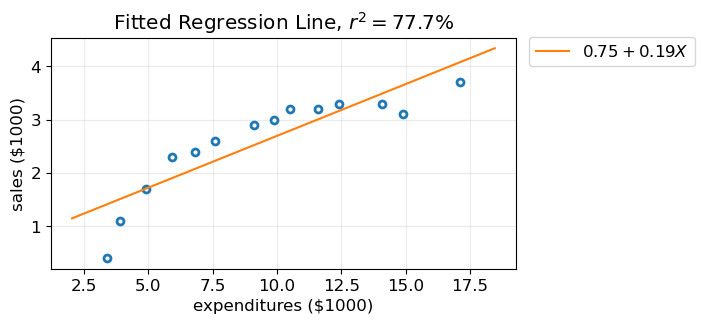

In [37]:
fig, ax = plt.subplots(figsize=(6, 3))

# compute coefficient of determination
_, _, [SST, SSR, SSE] = get_ANOVA_table(df_corr)
rSq = SSR/SST

ax.plot(df_corr["X"], df_corr["Y"], 
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='None', markeredgewidth=2) 

data_x_min = df_corr["X"].min()
data_x_max = df_corr["X"].max()
x_offset = 0.1*(data_x_max - data_x_min)
x_regress = np.linspace(data_x_min - x_offset, data_x_max + x_offset)
regress_label = r"${:.2f} + {:.2f}X$".format(b0, b1) \
  if b1 > 0 else r"${:.2f}{:.2f}X$".format(b0, b1)

ax.plot(x_regress, b0 + b1*x_regress, 
  linestyle='-',
  label=regress_label) 

ax.set_xlabel(r"expenditures ($1000)")
ax.set_ylabel(r"sales ($1000)")
ax.set_title(r"Fitted Regression Line, $r^2={:.1f}$%".format(rSq*100))

ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)

## Several transformation of $X$

In [20]:
df_transform = df_corr.copy()
df_transform = df_transform.drop(columns=["XY"])

df_transform["1/X"] = 1./df_transform['X']
df_transform["logX"] = np.log(df_transform['X'])
df_transform["sqrtX"] = np.sqrt(df_transform['X'])

df_transform

,Y,X,X^2,1/X,logX,sqrtX
0,1.1,3.9,15.21,0.256410,1.360977,1.974842
1,1.7,4.9,24.01,0.204082,1.589235,2.213594
2,2.6,7.6,57.76,0.131579,2.028148,2.756810
3,2.4,6.8,46.24,0.147059,1.916923,2.607681
4,2.3,5.9,34.81,0.169492,1.774952,2.428992
5,2.9,9.1,82.81,0.109890,2.208274,3.016621
6,0.4,3.4,11.56,0.294118,1.223775,1.843909
7,3.2,11.6,134.56,0.086207,2.451005,3.405877
8,3.3,14.1,198.81,0.070922,2.646175,3.754997
9,3.1,14.9,222.01,0.067114,2.701361,3.860052


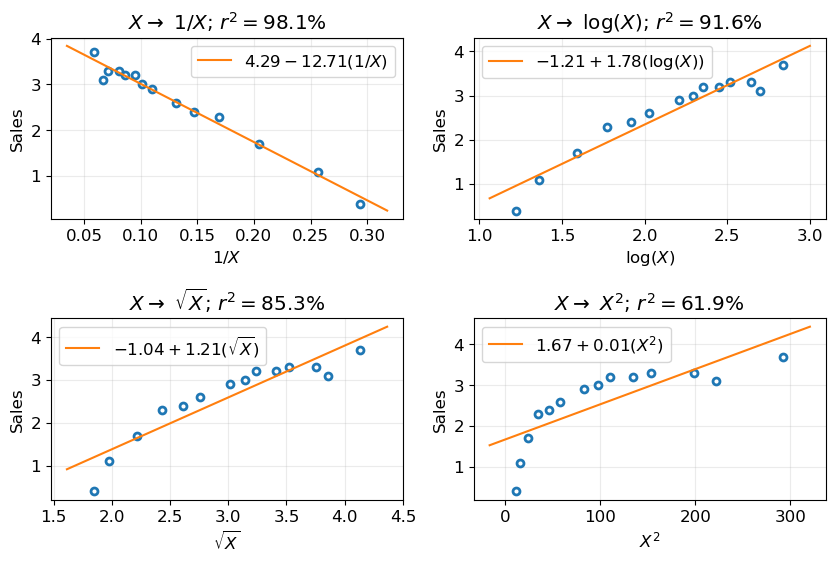

In [51]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

X_transform_name = [[r"$1/X$", r"$\log(X)$"],
                    [r"$\sqrt{X}$", r"$X^2$"]]

# Compute r^2 for each transformation
# and create a plot in each axis
X_transform_key = [["1/X", "logX"],
                   ["sqrtX", "X^2"]]
rSq_arr = np.zeros_like(X_transform_name)
for i, key_i in enumerate(X_transform_key):
  for j, key in enumerate(key_i):
    df_XY = df_corr.copy()
    df_XY['X'] = df_transform[key]
    [b0, b1], _ = get_regress_coeff(df_XY)

    data_x_min = df_transform[key].min()
    data_x_max = df_transform[key].max()
    x_offset = 0.1*(data_x_max - data_x_min)
    x_regress = np.linspace(data_x_min - x_offset, data_x_max + x_offset)
    sign_b1 = " + " if b1 > 0 else ""
    regress_label = r"${:.2f}{:}{:.2f}$".format(b0, sign_b1, b1) \
      + r"({:})".format(X_transform_name[i][j]) 
    
    axes[i, j].plot(df_transform[key], df_transform['Y'],
      marker='o', markersize=5, markerfacecolor='white',
      linestyle='None', markeredgewidth=2) 
    axes[i, j].plot(x_regress, b0 + b1*x_regress, 
      linestyle='-', label=regress_label) 

    _, _, [SST, SSR, SSE] = get_ANOVA_table(df_XY)
    rSq = SSR/SST

    # -- seting axes
    name = X_transform_name[i][j]
    axes[i, j].grid("on")
    axes[i, j].set_xlabel(name)
    axes[i, j].set_ylabel("Sales")
    axes[i, j].set_title(r"$X \rightarrow $ " + name 
      + r"; $r^2 = {:.1f}$%".format(rSq * 100))
    axes[i, j].legend(loc="best")


plt.subplots_adjust(hspace=0.55)
plt.show(fig)

After examining the multiple scatter diagram, Gil concludes that the relationships between:  
1. sales and the logarithms of advertising expenditures,    
2. sales and the square roots of adverttising expenditures,   
3. sales and the squares of advertising expenditures,      

all show some degree of curvature. These relationships are not linear. However, the relationship between sales and the reciprocals of advertising expenditures does appear to be linear with a negative slope. 

Gil fits a simple linear regression model to the sales and reciprocals of advertising expenditures data. He determines the fitted equation $\hat{Y} = 4.29 - 12.7(1/X)$ and
sees that $r^2 = 98.1\%$. A residual analysis indicates this lienar model is appropriate.